# Real data application

In [1]:
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import verde as vd
import harmonica as hm
import euler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data_dir = pathlib.Path("..") / "data"

In [4]:
data = pd.read_csv(data_dir / "rio-de-janeiro-magnetic.csv")
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m,deriv_up,deriv_east,deriv_north
0,-42.639984,-22.290527,-16.56,151.49,2800,-4.393928e+06,-2.342215e+06,0.159488,0.045283,-0.096695
1,-42.639969,-22.291397,-43.47,162.46,2800,-4.393926e+06,-2.342311e+06,0.118291,0.053503,-0.125651
2,-42.639954,-22.292267,-65.38,170.69,2800,-4.393925e+06,-2.342407e+06,0.065451,0.062132,-0.143214
3,-42.639938,-22.293152,-74.29,173.43,2800,-4.393923e+06,-2.342505e+06,0.003259,0.071041,-0.146666
4,-42.639923,-22.294022,-67.20,170.08,2800,-4.393922e+06,-2.342602e+06,-0.063629,0.079413,-0.132554
...,...,...,...,...,...,...,...,...,...,...
50877,-41.905685,-22.497009,163.33,143.87,4600,-4.318260e+06,-2.365096e+06,-0.022036,-0.000077,-0.043498
50878,-41.905685,-22.497879,175.29,142.34,4600,-4.318260e+06,-2.365192e+06,-0.033156,0.002121,-0.036070
50879,-41.905701,-22.498734,180.25,140.51,4600,-4.318262e+06,-2.365287e+06,-0.041334,0.004720,-0.027289
50880,-41.905701,-22.499588,175.21,138.68,4600,-4.318262e+06,-2.365382e+06,-0.046377,0.007345,-0.018021


In [5]:
%%time
window_size = 12e3
window_step = window_size / 5
euler_windows = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.1,
).fit(
    coordinates=(data.easting_m.values, data.northing_m.values, data.altitude_m.values),
    data=(
        data.total_field_anomaly_nT.values,
        data.deriv_east.values,
        data.deriv_north.values,
        data.deriv_up.values,
    ),
)

CPU times: user 397 ms, sys: 142 ms, total: 539 ms
Wall time: 2.41 s


In [6]:
areas = [
    [-4.39e6, -4.375e6, -2.345e6, -2.33e6],
    [-4.365e6, -4.345e6, -2.35e6, -2.33e6],
    [-4.35e6, -4.335e6, -2.34e6, -2.325e6],
    [-4.35e6, -4.33e6, -2.36e6, -2.340e6],
]
area_solutions = []
area_names = "ABCDE"
for area in areas:
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    coordinates = (
        data_area.easting_m.values,
        data_area.northing_m.values,
        data_area.altitude_m.values,
    )
    euler_data = (
        data_area.total_field_anomaly_nT.values,
        data_area.deriv_east.values,
        data_area.deriv_north.values,
        data_area.deriv_up.values,
    )
    candidates = []
    for si in [1, 2, 3]:
        candidates.append(
            euler.EulerInversion(structural_index=si).fit(coordinates, euler_data)
        )
    misfits = [ei.data_misfit_[1] for ei in candidates]
    best = candidates[np.argmin(misfits)]
    area_solutions.append(best)

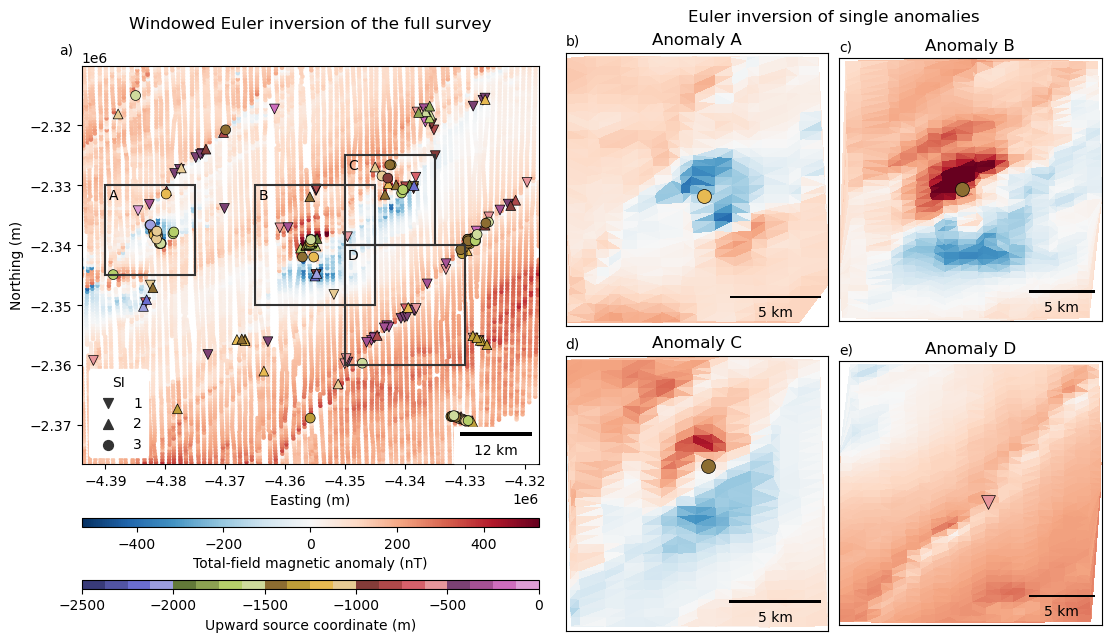

In [7]:
fig = plt.figure(figsize=(11, 6.3), layout="constrained")
figures = fig.subfigures(1, 2)

ax = figures[0].subplots(1, 1)
# figures[0].suptitle("Aeromagnetic data from Rio de Janeiro")
# scale = 0.9 * vd.maxabs(data.total_field_anomaly_nT)
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
    (data.easting_m, data.northing_m), data.total_field_anomaly_nT
)
tmp_data = ax.scatter(
    *block_coords, s=5, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r"
)
ax.set_title("Windowed Euler inversion of the full survey\n", pad=15)
ax.text(-0.05, 1.03, "a)", transform=ax.transAxes)
ax.set_aspect("equal")
ax.set_xlim(data.easting_m.min(), data.easting_m.max())
ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
markers = ["v", "^", "o"]
labels = {}
size = 50
vmin, vmax = -2500, 0
for si, marker in zip([1, 2, 3], markers):
    is_si = euler_windows.structural_indices_ == si
    tmp = ax.scatter(
        *euler_windows.locations_[:2, is_si],
        c=euler_windows.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
fig.colorbar(
    tmp_data,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Total-field magnetic anomaly (nT)",
)
ax.add_artist(
    ScaleBar(
        dx=0.001,
        fixed_value=window_size / 1000,
        units="km",
        location="lower right",
        # box_alpha=0,
        color="black",
        scale_loc="bottom",
        width_fraction=0.01,
        length_fraction=0.1,
        pad=0.4,
        scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
    )
)

for area, name in zip(areas, area_names):
    ax.add_patch(
        plt.Rectangle(
            xy=(area[0], area[2]),
            width=area[1] - area[0],
            height=area[3] - area[2],
            fill=None,
            edgecolor="#333333",
            linewidth=1.5,
        )
    )
    ax.text(area[0] + 0.5e3, area[3] - 0.5e3, name, verticalalignment="top")

axes = figures[1].subplots(2, 2)
figures[1].suptitle("Euler inversion of single anomalies")
for area, name, ei, ax, label in zip(
    areas, area_names, area_solutions, axes.ravel(), "bcde"
):
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
        (data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT
    )
    ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
    ax.set_aspect("equal")
    ax.set_xlim(data_area.easting_m.min(), data_area.easting_m.max())
    ax.set_ylim(data_area.northing_m.min(), data_area.northing_m.max())
    ax.set_title(f"Anomaly {name}")
    ax.tick_params(
        axis="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    tmp = ax.scatter(
        *ei.location_[:2],
        c=ei.location_[2],
        s=100,
        marker=markers[ei.structural_index - 1],
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    ax.add_artist(
        ScaleBar(
            dx=1,
            units="m",
            location="lower right",
            box_alpha=0,
            color="black",
            scale_loc="bottom",
            width_fraction=0.01,
            length_fraction=0.5,
            pad=0.4,
        )
    )
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

for dpi, res in zip([70, 300], ["", "-highres"]):
    fig.savefig(
        f"../paper/figures/real-data-application{res}.png",
        dpi=dpi,
        bbox_inches="tight",
    )

plt.show()